<a href="https://colab.research.google.com/github/DavidHeSkr/GCN-GAN-pytorch/blob/master/gcn_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
tf.keras.backend.clear_session()

TensorFlow 2.x selected.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np

In [0]:
def read_data(name_pre, time_index, node_num, max_thres):
    '''
    Function to read the network snapshot of specific time slice
    读取特定时间片下的网络快照的函数
    :param name_pre: the name prefix of the data file 数据文件名称前缀
    :param time_index: index of time slice 时间片索引
    :param node_num: number of nodes in the dynamic network 动态网络中节点总数
    :param max_thres: threshold of the maximum edge weight 最大边权值的阈值
    :return: adjacency matrix of the specific time slice 指定时间片的邻接矩阵
    '''
    #print('Read network snapshot #%d'%(time_index))
    #Initialize the adjacency matrix 初始化邻接矩阵
    curAdj = np.mat(np.zeros((node_num, node_num), dtype=np.float32))
    #Read the network snapshot of current time slice 读取当前时间片的网络快照
    f = open('%s_%d.txt'%(name_pre, time_index))
    line = f.readline()
    while line:
        seq = line.split()
        #print(seq)
        src = int(seq[0]) #Index of the source node 源节点索引
        tar = int(seq[1]) #Index of the target node 目的节点索引
        seq[2] = float(seq[2])
        if seq[2]>max_thres:
            seq[2] = max_thres

        #Update the adjacency matrix 更新邻接矩阵
        curAdj[src, tar] = seq[2]
        curAdj[tar, src] = seq[2]
        line = f.readline()
    f.close()
    return curAdj/max_thres

In [0]:
node_num = 38
window_size = 10
time_index = 1
max_thres = 2000
name_pre = "/content/drive/My Drive/graph-data/data/UCSB/edge_list"

In [0]:
# dimen of initial random feature of nodes
initial_feature_dim = 1
hidden_dim = 4
batch_size = 10
window_size = 10
lstm_dim = 38

class GCNLayer(layers.Layer):
  def __init__(self, num_outputs):
    super(GCNLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    #print("input shit is", input_shape)
    self.shape = input_shape
    self.kernel = self.add_weight("kernel",
                                    shape=[self.shape[-1],
                                           self.num_outputs],
                                           initializer=keras.initializers.RandomNormal(),
                                            trainable=True)

  def ran_feature(self, batch_size, window_size, node_dim, feature_dim):
    """
    generate a random feature matrix
    :param node_dim: number of rows of the noise matrix
    :param feature_dim: number of columns of the noise matrix
    :return: the feature matrix
    """
    return tf.random.normal([batch_size, window_size, node_dim, feature_dim],0,1)

  def call(self, input, training=True):
    identity_matrix = tf.broadcast_to(tf.eye(int(self.shape[-1])), self.shape)
    new_weight = tf.broadcast_to(self.kernel, [batch_size, window_size, self.shape[-1], self.num_outputs])
    A_hat = input + identity_matrix
    #print(A_hat.shape)
    #create a noise feature with the same dimension as the Ajacency matrix
    noise_feature = self.ran_feature(batch_size, window_size, self.shape[-1], node_num)
    D = tf.linalg.diag(tf.reduce_sum(A_hat, axis = -1) ** -0.5)
    #print(D.shape)
    temp_matrix = tf.matmul(tf.matmul(D, A_hat), D)
    #print(temp_matrix.shape)
    transformed_features = tf.matmul(temp_matrix, noise_feature)
    #return D*A_hat*D
    return tf.nn.relu(tf.matmul(transformed_features, new_weight))

layer = GCNLayer(hidden_dim)

In [0]:
class GEN(tf.keras.Model):
  def __init__(self):
    super(GEN, self).__init__(name='')
    self.gcn = GCNLayer(hidden_dim)
    self.lstm = layers.LSTM(lstm_dim, return_sequences=False)
    self.fc = layers.Dense(node_num*node_num)
    self.dropout = layers.Dropout(0.3)

  def call(self, input_tensor, training=True):
    x = self.gcn(input_tensor)
    x = tf.reshape(x, (batch_size, window_size, -1))
    x = self.lstm(x)
    x = self.fc(x)
    x = self.dropout(x)
    x = tf.nn.sigmoid(x)
    return x
    

In [0]:
class DIS(tf.keras.Model):
  def __init__(self):
    super(DIS, self).__init__(name='DIS')
    self.dense1 = layers.Dense(10, input_shape=(None, node_num * node_num))
    self.drop1 = layers.Dropout(0.3)
    self.dense2 = layers.Dense(1)

  def call(self, input_tensor, training=True):
    x = self.dense1(input_tensor)
    #print(x)
    x = self.drop1(x)
    x = tf.nn.relu(x)
    x = self.dense2(x)
    #print(x)
    return x

In [0]:
dis = DIS()

In [0]:
class WGAN(tf.keras.Model):
  def __init__(self, **kwargs):
    super(WGAN, self).__init__()
    self.__dict__.update(kwargs)

  def compute_loss(self, train_x):
    window_data, last_shot = train_x
    fake_data = self.gen(window_data)
    real_data = last_shot 
    real_data = tf.reshape(real_data, [batch_size, -1])
    #print("real_data: ", real_data.shape)
    #print(real_data)
    disc_real = self.disc(real_data)
    #print(disc_real)
    disc_fake = self.disc(fake_data)
    gen_loss = -tf.reduce_mean(disc_fake)
    disc_loss = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)
    return gen_loss, disc_loss

  @tf.function
  def train(self, train_x):
    #print("fake_data generated")
    #self.disc_optimizer.minimize(disc_loss)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        disc_loss, gen_loss = self.compute_loss(train_x)
    
    gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
    disc_gradients = [(tf.clip_by_value(grad, -1.0, 1.0))
                                  for grad in disc_gradients]
                                  
    self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
    self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    


In [0]:
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
generator = GEN()
discriminator = DIS()
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
)

In [0]:
def get_wei_KL(adj_est, gnd):
    '''
    Function to calculate the edge weight KL divergence
    :param adj_est: prediction result
    :param gnd: ground-truth
    :return: edge weight KL divergence
    '''
    sum_est = 0
    for r in range(node_num):
        for c in range(node_num):
            sum_est += adj_est[r, c]
    sum_gnd = 0
    for r in range(node_num):
        for c in range(node_num):
            sum_gnd += gnd[r, c]
    p = gnd/sum_gnd
    q = adj_est/sum_est
    edge_wei_KL = 0
    for r in range(node_num):
        for c in range(node_num):
            cur_KL = 0
            if q[r, c]>0 and p[r, c]>0:
                cur_KL = p[r, c]*np.log(p[r, c]/q[r, c])
            edge_wei_KL += cur_KL

    return edge_wei_KL

def get_mis_rate(adj_est, gnd):
    mis_sum = 0
    for r in range(node_num):
        for c in range(node_num):
            if (adj_est[r, c]>0 and gnd[r, c]==0) or (adj_est[r, c]==0 and gnd[r, c]>0):
                mis_sum += 1
    mis_rate = mis_sum/(node_num*node_num)

    return mis_rate

In [0]:
start_index = 0
end_index = 1000
def training_data_generater(start_index, end_index, window_size):
  start_index = start_index + window_size
  while start_index < end_index:
    temp = []
    for j in range(start_index-window_size, start_index):
      temp.append(read_data(name_pre, j, node_num, max_thres))
    temp = np.array(temp)
    predict_graph = read_data(name_pre, start_index, node_num, max_thres)
    yield temp, predict_graph
    start_index += 1
tf_train_Data = tf.data.Dataset.from_generator(training_data_generater, args=[start_index, end_index, window_size], output_types=(tf.float32, tf.float32), output_shapes = ((window_size, node_num, node_num),(node_num, node_num)))


In [82]:
from numpy import linalg as LA
n_epochs = 10

for epoch in range(n_epochs):
    print("1")
    # train
    for train_x in tf_train_Data.batch(10):
        model.train(train_x)
        f = open("+UCSB-LSTM_GAN_GCN-KL.txt", 'w')
        fw = open("+UCSB-LSTM_GAN_GCN-2.txt", 'w')
        
        window_data, real_data = train_x
        generated = model.gen(window_data)
        generated = tf.reshape(generated, [10,38,38]).numpy()
        train_x_last = real_data

        assert train_x_last.shape == generated.shape
        fw.write(str(train_x_last * max_thres))
        fw.write('\n')
        fw.close()
        print(LA.norm(train_x_last - generated))
        #f = open("+KAIST-LSTM_GAN_GCN_KL.txt", 'a+')
        f.write('%f' % (LA.norm(train_x_last - generated)))
        f.write(str(generated))
        f.write('\n')
        f.close()


1
59.85645
59.837013
59.805775
59.812473
59.817905
59.786976
59.817905
59.84073
59.833
59.820564
59.805965
59.83928
59.849148
59.805084
59.77234
59.747204
59.814472
59.765953
59.75599
59.7322
59.74161
59.738598
59.7584
59.72806
59.70294
59.694378
59.673206
59.684193
59.669266
59.640724
59.64318
59.610035
59.564346
59.593613
59.60507
59.568623
59.516594
59.50637
59.45711
59.437233
59.43128
59.386463
59.3888
59.289604
59.246895
59.270027
59.167007
59.152462
59.16621
59.058704
59.00089
58.974125
58.90502
58.915573
58.81729
58.735443
58.627872
58.5854
58.525063
58.415005
58.346764
58.209633
58.15788
58.04244
57.912586
57.81607
57.7194
57.578518
57.500217
57.362907
57.217354
57.07244
57.021114
56.8567
56.64326
56.586857
56.3322
56.292362
56.100754
55.979748
55.73663
55.698414
55.45688
55.196014
55.110462
54.956127
54.77621
54.487206
54.65406
54.44075
54.15668
54.130646
53.822784
53.63336
53.243664
52.94727
53.021168
52.749683
52.73912
1
52.560276
52.34309
52.13855
51.903355
51.676636
51.499

KeyboardInterrupt: ignored

In [0]:
#testing the generater way to generate dataset
def count(stop):
  i = 0
  while i<stop:
    yield (i, i*i)
    i += 1
    

In [0]:
[i for i in count(3)]

[(0, 0), (1, 1), (2, 4)]

In [0]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=(tf.int32, tf.int32), output_shapes = ((),()))

In [0]:
#for count_batch in ds_counter.repeat().batch(10).take(10):
for e in ds_counter.batch(10):
  a,b = e
  print(a,b)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32) tf.Tensor([ 0  1  4  9 16 25 36 49 64 81], shape=(10,), dtype=int32)
tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32) tf.Tensor([100 121 144 169 196 225 256 289 324 361], shape=(10,), dtype=int32)
tf.Tensor([20 21 22 23 24], shape=(5,), dtype=int32) tf.Tensor([400 441 484 529 576], shape=(5,), dtype=int32)


In [32]:
training_data_generater(start_index, end_index, window_size)

<generator object training_data_generater at 0x7f8f99b21f68>

In [0]:
tf_train_Data = tf.data.Dataset.from_generator(training_data_generater, args=[start_index, end_index, window_size], output_types=(tf.float32, tf.float32), output_shapes = ((window_size, node_num, node_num),(node_num, node_num)))


In [34]:
for e in tf_train_Data.batch(10):
  a,b = e
  print(a)
  print(b)
  break

tf.Tensor(
[[[[0.         0.         0.4560859  ... 0.         0.
    4.6353765 ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.4560859  0.         0.         ... 0.         0.
    1.7308663 ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [4.6353765  0.         1.7308663  ... 0.         0.
    0.        ]]

  [[0.         0.         0.4340291  ... 0.         0.
    1.7144485 ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.4340291  0.         0.         ... 0.         0.
    4.3682446 ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [1.7144485  0.         4.3682446  ... 0.         0.
    0.        ]]

  [[0.         0.         0.44638202 ... 0.         0.
    1.5319806 ]
   [0.         0.         0.         ... 0.     

In [0]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])

In [0]:
for r in t:
  print(r[-1])

tf.Tensor([2 2 2], shape=(3,), dtype=int32)
tf.Tensor([4 4 4], shape=(3,), dtype=int32)
tf.Tensor([6 6 6], shape=(3,), dtype=int32)


In [0]:
t

<tf.Tensor: shape=(3, 2, 3), dtype=int32, numpy=
array([[[1, 1, 1],
        [2, 2, 2]],

       [[3, 3, 3],
        [4, 4, 4]],

       [[5, 5, 5],
        [6, 6, 6]]], dtype=int32)>

In [0]:
t[-1]

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[5, 5, 5],
       [6, 6, 6]], dtype=int32)>

In [0]:
tf.slice(t, [1, 0, 0], [1,1,3])  

<tf.Tensor: shape=(1, 1, 3), dtype=int32, numpy=array([[[3, 3, 3]]], dtype=int32)>

In [83]:
!git init

Initialized empty Git repository in /content/.git/


In [86]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	+UCSB-LSTM_GAN_GCN-2.txt
	+UCSB-LSTM_GAN_GCN-KL.txt
	.config/
	drive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [85]:
!git origion add remote https://github.com/DavidHeSkr/GCN-GAN-TF2.0.git

git: 'origion' is not a git command. See 'git --help'.


In [0]:
38 * 38

1444

Read network snapshot #4


89.40487670898438

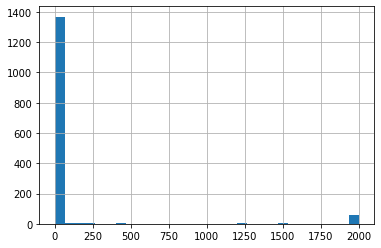

In [0]:
res = read_data(name_pre, 4, node_num, max_thres)
array_ = pd.Series(np.asarray(res.reshape(-1))[0])
array_.hist(bins = 30)
array_.mean()

In [0]:
print(layer(res))

[[0.00911977 0.         0.         ... 0.         0.         0.        ]
 [0.         0.16648394 0.         ... 0.         0.         0.        ]
 [0.         0.         0.10137379 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.9770347  0.         0.        ]
 [0.         0.         0.         ... 0.         0.0223375  0.        ]
 [0.         0.         0.         ... 0.         0.         0.02096626]]


In [0]:
layer(res)

s
38
Tensor("gcn_layer_1/mul_2:0", shape=(38, 38), dtype=float32)


<tf.Tensor 'gcn_layer_1/Sigmoid:0' shape=(38, 30) dtype=float32>

In [0]:
layer.kernel

<tf.Variable 'gcn_layer/kernel:0' shape=(38, 30) dtype=float32>

In [0]:
print(_)

<tf.Variable 'gcn_layer/kernel:0' shape=(38, 30) dtype=float32>
